# Notebook 08: Spatial Model Specification Tests

**Level**: Advanced  
**Duration**: 180-200 minutes  
**Prerequisites**: Notebooks 01-07 completed

---

## Objective

Master the art of spatial model selection through comprehensive specification testing. Learn:

- **LM tests** (Lagrange Multiplier) for initial model selection
- **LR tests** (Likelihood Ratio) for nested model comparison
- **Information criteria** (AIC/BIC) for non-nested models
- **Residual diagnostics** to check model adequacy
- **Sensitivity analysis** to W matrix specifications
- **Systematic workflow** for choosing the appropriate spatial model

---

## Prerequisites

✓ All spatial models understood (SAR, SEM, SDM, GNS)  
✓ Hypothesis testing (LR tests, χ² distribution)  
✓ Model selection theory (AIC/BIC)  
✓ Dataset: Housing prices with spatial structure

---

## 1. The Model Selection Problem

### Which Spatial Model Should I Use?

When faced with spatial data, we have multiple model options:

| Model | Equation | Key Feature |
|-------|----------|--------------|
| **OLS** | y = Xβ + ε | No spatial dependence |
| **SAR** | y = ρWy + Xβ + ε | Endogenous spillovers (spatial lag) |
| **SEM** | y = Xβ + u, u = λWu + ε | Error correlation |
| **SDM** | y = ρWy + Xβ + WXθ + ε | Both spillovers (lag + exogenous) |
| **SDEM** | y = Xβ + WXθ + u, u = λWu + ε | Exogenous spillovers + error |
| **GNS** | y = ρWy + Xβ + WXθ + u, u = λWu + ε | Full general model |

### Nested Model Hierarchy

```
                    GNS (most general)
                   /                  \
                SDM                  SDEM
               /   \                /    \
             SAR   SEM           SEM    SLX
               \   /
               OLS (most restricted)
```

### Decision Criteria

1. **Theory**: What does economic theory predict about spillovers?
2. **Tests**: LM tests (starting point), LR tests (nested comparison)
3. **Fit**: AIC, BIC, log-likelihood
4. **Diagnostics**: Residual spatial autocorrelation
5. **Robustness**: Sensitivity to W specification

### The Goal

Choose the **simplest model** that adequately captures spatial dependence (principle of parsimony).

In [1]:
# Setup
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import chi2, probplot, norm, t as t_dist
import warnings
warnings.filterwarnings('ignore')

# Add panelbox to path
panelbox_path = Path("/home/guhaase/projetos/panelbox")
sys.path.insert(0, str(panelbox_path))

from panelbox.models.spatial import SpatialLag, SpatialError, SpatialDurbin
# Must import from panelbox.core.spatial_weights — that is what SpatialPanelModel checks
from panelbox.core.spatial_weights import SpatialWeights
from libpysal.weights import Queen, Rook, KNN

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
output_dir = Path("../outputs/figures")
output_dir.mkdir(parents=True, exist_ok=True)

def pysal_to_panelbox(pysal_w):
    """Convert a row-standardized libpysal weights object to a panelbox SpatialWeights."""
    pysal_w.transform = 'r'
    return SpatialWeights(pysal_w.sparse, normalized=True)

print("Libraries loaded successfully")
print(f"Working directory: {Path.cwd()}")

Libraries loaded successfully
Working directory: /home/guhaase/projetos/panelbox/examples/spatial/notebooks


In [2]:
# Load or generate housing price data
data_path = Path("../data/housing_prices/housing_prices.csv")

if not data_path.exists():
    print("Data file not found. Generating synthetic housing price data...")

    grid_size = 17
    n = grid_size * grid_size  # 289 — perfect square for Queen contiguity

    # Create spatial grid with small random noise
    x_coords = np.repeat(np.arange(grid_size), grid_size)
    y_coords = np.tile(np.arange(grid_size), grid_size)

    longitude = -122.4 + x_coords * 0.01 + np.random.normal(0, 0.002, n)
    latitude  =  37.7 + y_coords * 0.01 + np.random.normal(0, 0.002, n)

    # Generate covariates
    bedrooms = np.clip(np.random.poisson(3, n) + 1, 1, 7)
    sqft     = np.clip(np.random.normal(2000, 500, n), 800, 4000)
    age      = np.clip(np.random.exponential(15, n), 0, 80)
    garage   = np.random.binomial(1, 0.7, n)

    raw_data = pd.DataFrame({
        'longitude': longitude, 'latitude': latitude,
        'bedrooms': bedrooms, 'sqft': sqft,
        'age': age, 'garage': garage, 'year': 2020
    })

    # Build temporary W for data generation
    geo_tmp = gpd.GeoDataFrame(
        raw_data,
        geometry=gpd.points_from_xy(raw_data.longitude, raw_data.latitude)
    )
    W_tmp = Queen.from_dataframe(geo_tmp)
    W_tmp.transform = 'r'

    # True DGP: y = (I - rho*W)^(-1)(Xbeta + eps)
    rho_true = 0.5
    X_base = (200000 + 50000*bedrooms + 150*sqft - 2000*age + 30000*garage)
    epsilon  = np.random.normal(0, 50000, n)
    W_arr   = W_tmp.sparse.toarray()
    A_inv   = np.linalg.inv(np.eye(n) - rho_true * W_arr)
    raw_data['price'] = A_inv @ (X_base + epsilon)

    data_path.parent.mkdir(parents=True, exist_ok=True)
    raw_data.to_csv(data_path, index=False)
    print(f"Synthetic data saved to {data_path} (n={n})")

data = pd.read_csv(data_path)

print("\n" + "="*80)
print("HOUSING PRICE DATA")
print("="*80)
print(data.head(8).to_string())
print(f"\nShape: {data.shape}")
print("\nSummary statistics:")
print(data[['price', 'bedrooms', 'sqft', 'age', 'garage']].describe().round(2))


HOUSING PRICE DATA
    longitude   latitude  bedrooms         sqft        age  garage  year         price
0 -122.399007  37.698755         4  2138.991532   8.553220       1  2020  1.397560e+06
1 -122.400277  37.709584         4  2727.405322  22.300319       1  2020  1.405954e+06
2 -122.398705  37.719014         4  1275.071717  13.816664       1  2020  1.189777e+06
3 -122.396954  37.728821         3  1446.845909  33.457217       1  2020  1.205248e+06
4 -122.400468  37.741699         6  1772.905221   8.788088       0  2020  1.429643e+06
5 -122.400468  37.750714         3  1589.828088  14.012604       0  2020  1.286362e+06
6 -122.396842  37.758614         3  1591.407267  14.966887       1  2020  1.334592e+06
7 -122.398465  37.771799         6   952.939686  13.436192       0  2020  1.406405e+06

Shape: (289, 8)

Summary statistics:
            price  bedrooms     sqft     age  garage
count      289.00    289.00   289.00  289.00  289.00
mean   1373219.42      3.93  2004.88   14.59    0.70


## 2. Lagrange Multiplier (LM) Tests

### Starting Point: Test OLS Residuals

LM tests (Anselin et al., 1996) help us decide which spatial model to use by testing OLS residuals for spatial patterns **without** estimating a spatial model.

### Four LM Tests

| Test | Null Hypothesis | Interpretation |
|------|----------------|----------------|
| **LM-lag** | H₀: ρ = 0 | Do we need a spatial lag (SAR)? |
| **LM-error** | H₀: λ = 0 | Do we need spatial errors (SEM)? |
| **Robust LM-lag** | H₀: ρ = 0 \| λ ≠ 0 | LM-lag adjusted for possible SEM |
| **Robust LM-error** | H₀: λ = 0 \| ρ ≠ 0 | LM-error adjusted for possible SAR |

### Decision Tree (Anselin et al., 1996)

```
LM-lag significant?   LM-error significant?     Decision
─────────────────────────────────────────────────────────
       No                     No            →  OLS is fine
       Yes                    No            →  Use SAR
       No                     Yes           →  Use SEM
       Yes                    Yes      ─────┐
                                            ↓
       Robust LM-lag sig?   Robust LM-error sig?   Decision
       ──────────────────────────────────────────────────────
              Yes                  No         →  Use SAR
              No                   Yes        →  Use SEM
              Yes                  Yes        →  Use SDM or GNS
```

In [3]:
from sklearn.linear_model import LinearRegression

# Prepare variables
X_vars = ['bedrooms', 'sqft', 'age', 'garage']
X = data[X_vars].values
y = data['price'].values

# OLS estimation
ols = LinearRegression()
ols.fit(X, y)
residuals_ols = y - ols.predict(X)

# OLS summary
ss_res = np.sum(residuals_ols**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_ols = 1 - ss_res / ss_tot

print("="*70)
print("OLS BASELINE")
print("="*70)
print(f"{'Variable':<15} {'Coefficient':>15}")
print("-"*35)
print(f"{'Intercept':<15} {ols.intercept_:>15,.0f}")
for v, c in zip(X_vars, ols.coef_):
    print(f"{v:<15} {c:>15,.2f}")
print("-"*35)
print(f"R²: {r2_ols:.4f}")
print(f"Residual std: {np.std(residuals_ols):,.0f}")
print("="*70)

OLS BASELINE
Variable            Coefficient
-----------------------------------
Intercept               879,711
bedrooms              50,578.99
sqft                     159.31
age                   -2,431.03
garage                15,661.22
-----------------------------------
R²: 0.7981
Residual std: 61,863


In [4]:
# Build spatial weights matrix
geo = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude)
)

# libpysal W (used directly by the LM test functions via .sparse attribute)
W_pysal = Queen.from_dataframe(geo)
W_pysal.transform = 'r'  # Row-standardize

# panelbox SpatialWeights (required by SpatialLag/SpatialError/SpatialDurbin)
W = pysal_to_panelbox(W_pysal)

print("="*70)
print("SPATIAL WEIGHTS MATRIX (W)")
print("="*70)
print(f"Type: Queen contiguity (row-standardized)")
print(f"Observations: {W_pysal.n}")
print(f"Average neighbors: {W_pysal.mean_neighbors:.2f}")
print(f"Min/Max neighbors: {W_pysal.min_neighbors} / {W_pysal.max_neighbors}")
print(f"Non-zero links: {sum(len(v) for v in W_pysal.neighbors.values())}")
print("="*70)

SPATIAL WEIGHTS MATRIX (W)
Type: Queen contiguity (row-standardized)
Observations: 289
Average neighbors: 5.54
Min/Max neighbors: 2 / 8
Non-zero links: 1602


In [5]:
def compute_lm_tests(residuals, X, W_lm, y):
    """
    Compute the four LM tests for spatial dependence.

    Following Anselin, Bera, Florax & Yoon (1996):
    'Simple diagnostic tests for spatial dependence'
    Regional Science and Urban Economics, 26, 77-104.

    Parameters
    ----------
    residuals : array-like
        OLS residuals
    X : array-like
        Design matrix (without intercept)
    W_lm : libpysal weights object OR panelbox SpatialWeights OR scipy sparse
        Row-standardized spatial weights (must have a .sparse attribute or be sparse)
    y : array-like
        Dependent variable

    Returns
    -------
    dict of test results
    """
    n = len(residuals)
    e = residuals

    # Add intercept to X
    X_const = np.column_stack([np.ones(n), X])

    # Residual variance
    s2 = np.sum(e**2) / n

    # Sparse W matrix — handle libpysal, panelbox SpatialWeights, or raw scipy sparse
    if hasattr(W_lm, 'sparse') and callable(getattr(type(W_lm), 'sparse', None)):
        # libpysal weights: .sparse is a property returning a csr_matrix
        W_sparse = W_lm.sparse
    elif hasattr(W_lm, 'sparse') and hasattr(W_lm.sparse, 'toarray'):
        # scipy sparse matrix stored as attribute
        W_sparse = W_lm.sparse
    elif hasattr(W_lm, 'matrix') and hasattr(W_lm.matrix, 'toarray'):
        # panelbox SpatialWeights with sparse matrix
        W_sparse = W_lm.matrix
    elif hasattr(W_lm, 'toarray'):
        W_sparse = W_lm
    else:
        from scipy.sparse import csr_matrix
        W_sparse = csr_matrix(np.asarray(W_lm))

    # Spatial lags
    Wy = W_sparse @ y
    We = W_sparse @ e

    # Annihilator matrix: M = I - X(X'X)^-1 X'
    XtX_inv = np.linalg.inv(X_const.T @ X_const)
    M = np.eye(n) - X_const @ XtX_inv @ X_const.T

    # T = trace(W'W + W^2)
    WtW = W_sparse.T @ W_sparse
    W2  = W_sparse @ W_sparse
    T   = (WtW + W2).diagonal().sum()

    # ──────────────────────────────────────
    # LM-error (Burridge 1980)
    # LM_err = [e'We / s²]² / T
    # ──────────────────────────────────────
    lm_error = (e @ We / s2)**2 / T
    p_lm_error = 1 - chi2.cdf(lm_error, 1)

    # ──────────────────────────────────────
    # LM-lag (Anselin 1988)
    # LM_lag = [e'Wy / s²]² / J
    # J = (1/n)(Wy)'M(Wy)/s² + T
    # ──────────────────────────────────────
    MWy   = M @ Wy
    J     = (Wy @ M @ Wy) / (n * s2) + T
    lm_lag = (e @ Wy / s2)**2 / J
    p_lm_lag = 1 - chi2.cdf(lm_lag, 1)

    # ──────────────────────────────────────
    # Robust LM-lag (robust to presence of SEM)
    # RLM_lag = [e'Wy/s² - e'We/s²]² / (J - T)
    # ──────────────────────────────────────
    numerator_rlag = (e @ Wy / s2 - e @ We / s2)**2
    robust_lm_lag  = numerator_rlag / (J - T)
    p_robust_lm_lag = 1 - chi2.cdf(robust_lm_lag, 1)

    # ──────────────────────────────────────
    # Robust LM-error (robust to presence of SAR)
    # RLM_err = [e'We/s² - T/n * e'Wy/s²]² / (T - T²/(nJ))
    # ──────────────────────────────────────
    numerator_rerr  = (e @ We / s2 - (T / J) * e @ Wy / s2)**2
    denom_rerr      = T * (1 - T / (n * J))
    robust_lm_error = numerator_rerr / denom_rerr
    p_robust_lm_error = 1 - chi2.cdf(robust_lm_error, 1)

    return {
        'LM-lag':         {'statistic': lm_lag,         'p_value': p_lm_lag},
        'LM-error':       {'statistic': lm_error,       'p_value': p_lm_error},
        'Robust LM-lag':  {'statistic': robust_lm_lag,  'p_value': p_robust_lm_lag},
        'Robust LM-error':{'statistic': robust_lm_error,'p_value': p_robust_lm_error},
    }


# Run LM tests using the libpysal W (which has .sparse attribute compatible with sparse ops)
lm_results = compute_lm_tests(residuals_ols, X, W_pysal, y)

print("\nLAGRANGE MULTIPLIER TESTS")
print("="*80)
print(f"{'Test':<25} {'Statistic':>12} {'p-value':>12} {'df':>4} {'Conclusion':>20}")
print("-"*80)

for test_name, result in lm_results.items():
    stat  = result['statistic']
    pval  = result['p_value']
    concl = 'Significant **' if pval < 0.05 else 'Not significant'
    print(f"{test_name:<25} {stat:>12.3f} {pval:>12.4f} {1:>4} {concl:>20}")

print("="*80)


LAGRANGE MULTIPLIER TESTS
Test                         Statistic      p-value   df           Conclusion
--------------------------------------------------------------------------------
LM-lag                         314.200       0.0000    1       Significant **
LM-error                        65.363       0.0000    1       Significant **
Robust LM-lag                 8787.852       0.0000    1       Significant **
Robust LM-error                 91.441       0.0000    1       Significant **


In [6]:
# Apply decision tree
lm_lag_p     = lm_results['LM-lag']['p_value']
lm_error_p   = lm_results['LM-error']['p_value']
robust_lag_p = lm_results['Robust LM-lag']['p_value']
robust_err_p = lm_results['Robust LM-error']['p_value']

alpha = 0.05

if lm_lag_p >= alpha and lm_error_p >= alpha:
    recommendation = "OLS (no spatial dependence)"
    explanation    = "Neither LM test is significant"
elif lm_lag_p < alpha and lm_error_p >= alpha:
    recommendation = "SAR (spatial lag model)"
    explanation    = "Only LM-lag significant → endogenous spatial spillovers"
elif lm_error_p < alpha and lm_lag_p >= alpha:
    recommendation = "SEM (spatial error model)"
    explanation    = "Only LM-error significant → spatial error correlation"
else:
    if robust_lag_p < alpha and robust_err_p >= alpha:
        recommendation = "SAR"
        explanation    = "Both LM significant, but robust LM-lag dominates"
    elif robust_err_p < alpha and robust_lag_p >= alpha:
        recommendation = "SEM"
        explanation    = "Both LM significant, but robust LM-error dominates"
    else:
        recommendation = "SDM or GNS (complex spatial structure)"
        explanation    = "Both robust tests significant → need more flexible model"

print("\nDECISION TREE RECOMMENDATION")
print("="*70)
print(f"\nRecommended model: {recommendation}")
print(f"Rationale: {explanation}")
print("="*70)


DECISION TREE RECOMMENDATION

Recommended model: SDM or GNS (complex spatial structure)
Rationale: Both robust tests significant → need more flexible model


LM test visualization saved


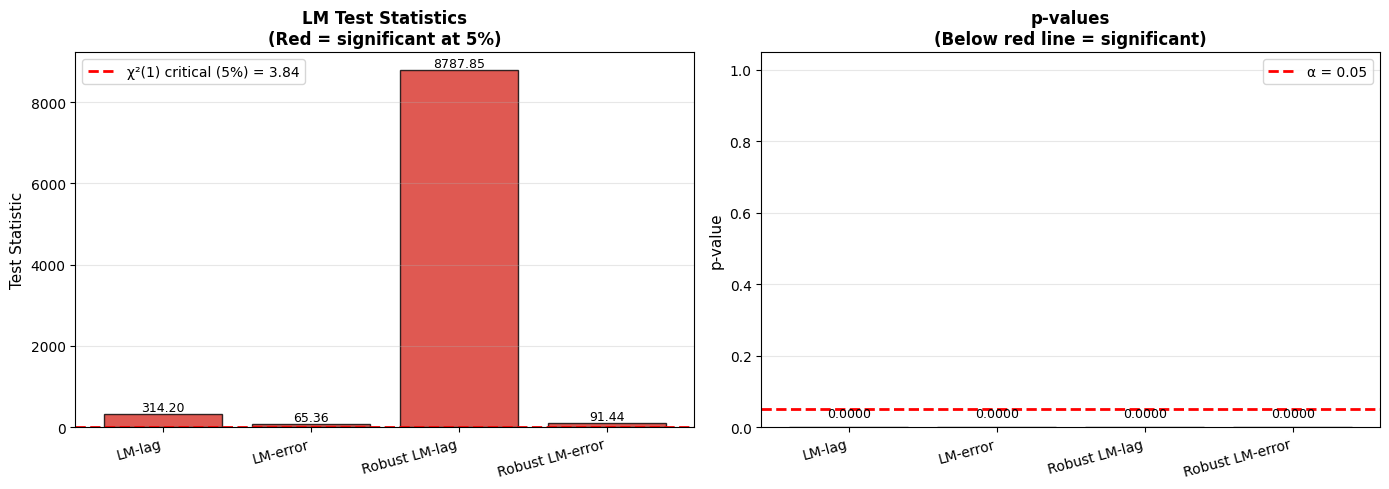

In [7]:
# Visualize LM test statistics vs chi-squared critical value
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of LM statistics
test_names = list(lm_results.keys())
stats_vals  = [v['statistic'] for v in lm_results.values()]
pvals       = [v['p_value']   for v in lm_results.values()]
colors      = ['#d73027' if p < 0.05 else '#4575b4' for p in pvals]

bars = axes[0].bar(range(len(test_names)), stats_vals, color=colors,
                   edgecolor='black', alpha=0.8)
axes[0].axhline(chi2.ppf(0.95, 1), color='red', linestyle='--', linewidth=2,
                label=f'χ²(1) critical (5%) = {chi2.ppf(0.95, 1):.2f}')
axes[0].set_xticks(range(len(test_names)))
axes[0].set_xticklabels(test_names, rotation=15, ha='right')
axes[0].set_ylabel('Test Statistic', fontsize=11)
axes[0].set_title('LM Test Statistics\n(Red = significant at 5%)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars, stats_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# Right: p-value chart
bars2 = axes[1].bar(range(len(test_names)), pvals, color=colors, edgecolor='black', alpha=0.8)
axes[1].axhline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[1].set_xticks(range(len(test_names)))
axes[1].set_xticklabels(test_names, rotation=15, ha='right')
axes[1].set_ylabel('p-value', fontsize=11)
axes[1].set_title('p-values\n(Below red line = significant)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.05])

for bar, val in zip(bars2, pvals):
    axes[1].text(bar.get_x() + bar.get_width()/2, min(val + 0.02, 0.98),
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'nb08_lm_tests.png', dpi=300, bbox_inches='tight')
print("LM test visualization saved")
plt.show()

### Interpretation

The LM tests provide a **statistical starting point** for model selection:

- If both standard LM tests are significant, examine the **robust versions** to break the tie
- Robust tests account for the possible presence of the other type of spatial dependence
- This decision tree is **data-driven** and should be combined with economic theory

**Next step**: Estimate candidate models and compare them using formal tests.

## 3. Likelihood Ratio (LR) Tests

### Testing Nested Models

LR tests compare **nested** models by exploiting the log-likelihood:

$$
LR = 2\left(\mathcal{L}_{\text{unrestricted}} - \mathcal{L}_{\text{restricted}}\right) \sim \chi^2(df)
$$

where $df$ = number of restrictions imposed by the restricted model.

### Testable Nested Restrictions

| Comparison | Restriction | df | Interpretation |
|------------|------------|----|-----------------|
| SDM vs SAR | H₀: θ = 0 | K | Are WX terms needed? |
| SDM vs OLS | H₀: ρ=0, θ=0 | K+1 | Does SDM beat OLS? |
| SAR vs OLS | H₀: ρ = 0 | 1 | Does spatial lag help? |

**Decision rule**: If LR is significant → prefer unrestricted model.

In [8]:
# Prepare data for panelbox models
data['entity_id'] = data.index
data['time']      = data['year']

print("Estimating spatial models...")
print("This may take a couple of minutes.\n")

Estimating spatial models...
This may take a couple of minutes.



In [9]:
# Estimate SAR (Spatial Lag) model
print("[1/3] Estimating SAR model (Pooled QML)...")
sar_model = SpatialLag(
    formula="price ~ bedrooms + sqft + age + garage",
    data=data,
    entity_col='entity_id',
    time_col='time',
    W=W
)
sar_results = sar_model.fit(effects='pooled', method='qml')
print(f"  SAR log-likelihood: {sar_results.llf:.4f}")
print(f"  SAR rho:            {sar_results.rho:.4f}")
print("  SAR estimation complete")

[1/3] Estimating SAR model (Pooled QML)...


  SAR log-likelihood: -3544.1097
  SAR rho:            0.4849
  SAR estimation complete


In [10]:
# Estimate SEM (Spatial Error) model
print("[2/3] Estimating SEM model (Pooled GMM)...")
sem_model = SpatialError(
    formula="price ~ bedrooms + sqft + age + garage",
    data=data,
    entity_col='entity_id',
    time_col='time',
    W=W
)
sem_results = sem_model.fit(effects='pooled', method='gmm')
lambda_val  = sem_results.params['lambda']
print(f"  SEM log-likelihood: {sem_results.llf:.4f}")
print(f"  SEM lambda:         {lambda_val:.4f}")
print("  SEM estimation complete")

[2/3] Estimating SEM model (Pooled GMM)...


  SEM log-likelihood: -4015.6053
  SEM lambda:         -0.1126
  SEM estimation complete


In [11]:
# Estimate SDM (Spatial Durbin) model
# Note: with T=1 (cross-sectional data) we use pooled QML (no entity fixed effects)
print("[3/3] Estimating SDM model (Pooled QML)...")
sdm_model = SpatialDurbin(
    formula="price ~ bedrooms + sqft + age + garage",
    data=data,
    entity_col='entity_id',
    time_col='time',
    W=W
)
# Use effects='pooled' since the dataset is cross-sectional (T=1)
sdm_results = sdm_model.fit(effects='pooled', method='qml')

# SDM stores log_likelihood as attribute (via kwargs)
sdm_llf = getattr(sdm_results, 'log_likelihood', None) or getattr(sdm_results, 'llf', None)
print(f"  SDM log-likelihood: {sdm_llf:.4f}")
print(f"  SDM rho:            {sdm_results.rho:.4f}")
print("  SDM estimation complete")
print("\nAll models estimated successfully!")

[3/3] Estimating SDM model (Pooled QML)...


  SDM log-likelihood: -3540.8749
  SDM rho:            0.5038
  SDM estimation complete

All models estimated successfully!


In [12]:
# Compute LR tests
# Note: LR tests require both models estimated with (quasi-)maximum likelihood
# SEM uses GMM so LR vs SAR is only approximate

sar_llf = sar_results.llf
sem_llf = sem_results.llf
sdm_llf = getattr(sdm_results, 'log_likelihood', getattr(sdm_results, 'llf', np.nan))

# OLS log-likelihood for comparison
n_obs      = len(y)
sigma2_ols = np.sum(residuals_ols**2) / n_obs
ols_llf    = -n_obs/2 * np.log(2 * np.pi * sigma2_ols) - n_obs/2

# LR test: SAR vs OLS (H0: rho = 0)
lr_sar_ols = 2 * (sar_llf - ols_llf)
p_sar_ols  = 1 - chi2.cdf(lr_sar_ols, 1)

# LR test: SDM vs SAR (H0: theta = 0)
lr_sdm_sar = 2 * (sdm_llf - sar_llf)
df_sdm_sar = len(X_vars)  # Number of WX terms = K
p_sdm_sar  = 1 - chi2.cdf(lr_sdm_sar, df_sdm_sar)

# LR test: SDM vs OLS (H0: rho = 0 and theta = 0)
lr_sdm_ols = 2 * (sdm_llf - ols_llf)
df_sdm_ols = 1 + len(X_vars)  # rho + K theta params
p_sdm_ols  = 1 - chi2.cdf(lr_sdm_ols, df_sdm_ols)

print("\nLIKELIHOOD RATIO TESTS")
print("="*90)
print(f"{'Comparison':<35} {'LR Stat':>10} {'df':>5} {'p-value':>10} {'Decision':>20}")
print("-"*90)

lr_tests = [
    ("SAR vs OLS (H0: ρ=0)",       lr_sar_ols, 1,         p_sar_ols,  'SAR', 'OLS'),
    ("SDM vs SAR (H0: θ=0)",       lr_sdm_sar, df_sdm_sar, p_sdm_sar,  'SDM', 'SAR'),
    ("SDM vs OLS (H0: ρ=0, θ=0)",  lr_sdm_ols, df_sdm_ols, p_sdm_ols,  'SDM', 'OLS'),
]

for comp, lr, df_lr, pval, unrestr, restr in lr_tests:
    decision = f"Prefer {unrestr}" if pval < 0.05 else f"Prefer {restr}"
    print(f"{comp:<35} {lr:>10.3f} {df_lr:>5} {pval:>10.4f} {decision:>20}")

print("="*90)

print("\nInterpretation:")
if p_sdm_sar < 0.05:
    print("  → WX terms are jointly significant → SDM better than SAR")
    print("  → Exogenous spatial spillovers are present")
else:
    print("  → WX terms not jointly significant → SAR adequate")
    print("  → No evidence for exogenous spatial spillovers")


LIKELIHOOD RATIO TESTS
Comparison                             LR Stat    df    p-value             Decision
------------------------------------------------------------------------------------------
SAR vs OLS (H0: ρ=0)                   108.818     1     0.0000           Prefer SAR
SDM vs SAR (H0: θ=0)                     6.470     4     0.1667           Prefer SAR
SDM vs OLS (H0: ρ=0, θ=0)              115.288     5     0.0000           Prefer SDM

Interpretation:
  → WX terms not jointly significant → SAR adequate
  → No evidence for exogenous spatial spillovers


## 4. Information Criteria (AIC/BIC)

### Comparing Non-Nested Models

When models are not nested (e.g., SAR vs SEM), we use **information criteria** which penalize model complexity:

$$
\text{AIC} = -2\mathcal{L} + 2k \qquad \text{BIC} = -2\mathcal{L} + k \cdot \ln(N)
$$

where $k$ = number of parameters, $N$ = sample size.

**Rules of thumb**:
- **Lower is better**
- BIC penalizes complexity more heavily (especially when N is large)
- ΔAIC or ΔBIC ≥ 10 indicates strong preference for the lower-AIC/BIC model
- For large N (> 100), BIC tends to be preferred

### AIC Weights (Akaike Weights)

$$
w_i = \frac{\exp(-\Delta_i/2)}{\sum_j \exp(-\Delta_j/2)}
$$

where $\Delta_i = \text{AIC}_i - \text{AIC}_{\min}$. Interpreted as the **probability** that model $i$ is the best.

In [13]:
# Model comparison table
# Compute OLS AIC/BIC manually
k_ols  = len(X_vars) + 2  # intercept + sigma2
aic_ols = -2 * ols_llf + 2 * k_ols
bic_ols = -2 * ols_llf + k_ols * np.log(n_obs)

model_stats = [
    {'Model': 'OLS', 'Log-Likelihood': ols_llf, 'Parameters': k_ols,
     'AIC': aic_ols, 'BIC': bic_ols},
    {'Model': 'SAR', 'Log-Likelihood': sar_results.llf, 'Parameters': sar_results.df_model,
     'AIC': sar_results.aic, 'BIC': sar_results.bic},
    {'Model': 'SEM', 'Log-Likelihood': sem_results.llf, 'Parameters': sem_results.df_model,
     'AIC': sem_results.aic, 'BIC': sem_results.bic},
    {'Model': 'SDM', 'Log-Likelihood': sdm_llf,        'Parameters': sdm_results.df_model,
     'AIC': sdm_results.aic, 'BIC': sdm_results.bic},
]

comp_df = pd.DataFrame(model_stats).sort_values('AIC')

# Compute delta-AIC and AIC weights
best_aic = comp_df['AIC'].min()
best_bic = comp_df['BIC'].min()

comp_df['ΔAIC']    = comp_df['AIC'] - best_aic
comp_df['ΔBIC']    = comp_df['BIC'] - best_bic

# AIC weights
exp_delta          = np.exp(-comp_df['ΔAIC'] / 2)
comp_df['w_AIC']   = exp_delta / exp_delta.sum()

print("\nMODEL COMPARISON: INFORMATION CRITERIA")
print("="*100)
print(comp_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print("="*100)

best_aic_model = comp_df.iloc[0]['Model']
best_bic_model = comp_df.loc[comp_df['BIC'].idxmin(), 'Model']

print(f"\nBest model by AIC: {best_aic_model}  (w_AIC = {comp_df.iloc[0]['w_AIC']:.3f})")
print(f"Best model by BIC: {best_bic_model}")

if best_aic_model != best_bic_model:
    print("\n→ AIC and BIC disagree:")
    print("  BIC penalizes complexity more → prefer simpler model")
    print(f"  With N = {n_obs}, BIC penalty per parameter = {np.log(n_obs):.2f} (vs AIC = 2)")
else:
    print(f"\nBoth AIC and BIC agree: {best_aic_model} is the best model")


MODEL COMPARISON: INFORMATION CRITERIA
Model  Log-Likelihood  Parameters     AIC     BIC   ΔAIC   ΔBIC  w_AIC
  SAR        -3544.11           6 7100.22 7122.22   0.00   0.00   0.85
  SDM        -3540.87          11 7103.75 7144.08   3.53  21.86   0.15
  OLS        -3598.52           6 7209.04 7231.04 108.82 108.82   0.00
  SEM        -4015.61           6 8043.21 8065.21 942.99 942.99   0.00

Best model by AIC: SAR  (w_AIC = 0.854)
Best model by BIC: SAR

Both AIC and BIC agree: SAR is the best model


In [14]:
# Detailed comparison with spatial parameters
print("\nDETAILED MODEL COMPARISON")
print("="*90)
print(f"{'Model':<6} {'ρ (lag)':>10} {'λ (err)':>10} {'Intercept':>14} "
      f"{'β_sqft':>10} {'Log-Lik':>12} {'AIC':>10}")
print("-"*90)

# OLS
print(f"{'OLS':<6} {'—':>10} {'—':>10} {ols.intercept_:>14,.0f} "
      f"{ols.coef_[1]:>10.2f} {ols_llf:>12.2f} {aic_ols:>10.2f}")

# SAR
sar_intercept = sar_results.params.get('Intercept', sar_results.params.iloc[1] if 'rho' in sar_results.params.index else sar_results.params.iloc[0])
sar_sqft = sar_results.params.get('sqft', sar_results.params.get('x2', float('nan')))
print(f"{'SAR':<6} {sar_results.rho:>10.4f} {'—':>10} {'—':>14} "
      f"{sar_sqft:>10.2f} {sar_results.llf:>12.2f} {sar_results.aic:>10.2f}")

# SEM
sem_sqft = sem_results.params.get('sqft', sem_results.params.get('x2', float('nan')))
print(f"{'SEM':<6} {'—':>10} {lambda_val:>10.4f} {'—':>14} "
      f"{sem_sqft:>10.2f} {sem_results.llf:>12.2f} {sem_results.aic:>10.2f}")

# SDM
sdm_sqft = sdm_results.params.get('sqft', sdm_results.params.get('x2', float('nan')))
print(f"{'SDM':<6} {sdm_results.rho:>10.4f} {'—':>10} {'—':>14} "
      f"{sdm_sqft:>10.2f} {sdm_llf:>12.2f} {sdm_results.aic:>10.2f}")

print("="*90)


DETAILED MODEL COMPARISON
Model     ρ (lag)    λ (err)      Intercept     β_sqft      Log-Lik        AIC
------------------------------------------------------------------------------------------
OLS             —          —        879,711     159.31     -3598.52    7209.04
SAR        0.4849          —              —     152.18     -3544.11    7100.22
SEM             —    -0.1126              —     684.54     -4015.61    8043.21
SDM        0.5038          —              —     150.37     -3540.87    7103.75


Model comparison plot saved


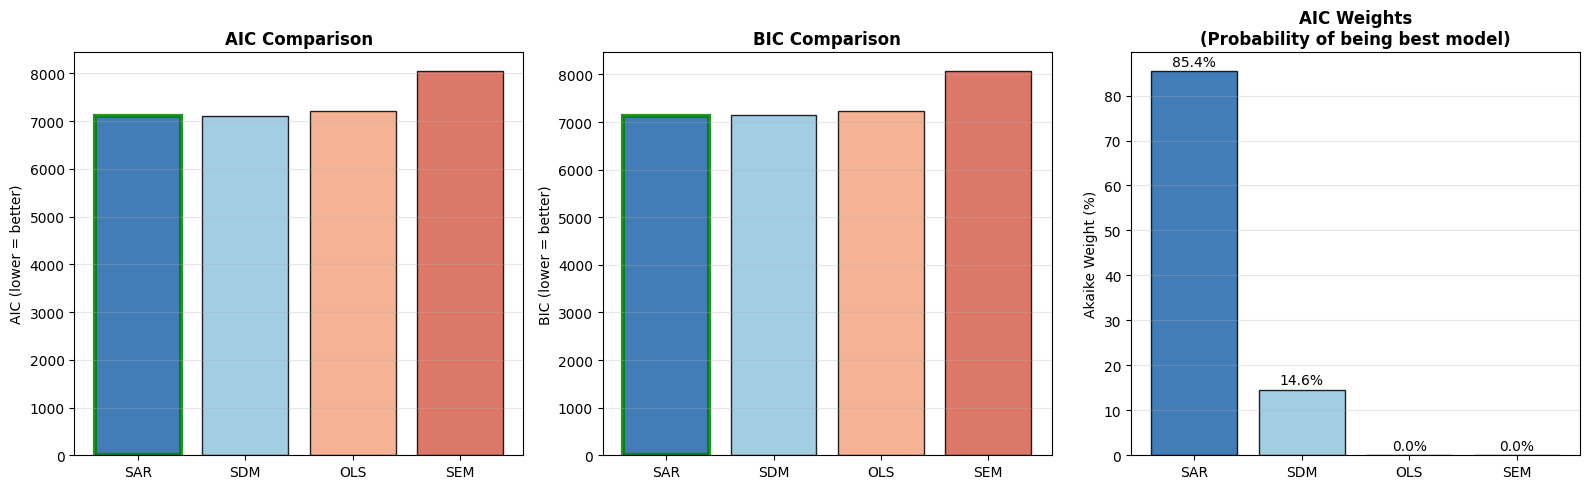

In [15]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_list = comp_df['Model'].tolist()
x_pos = np.arange(len(models_list))
palette = ['#2166ac', '#92c5de', '#f4a582', '#d6604d']

# AIC
bars_aic = axes[0].bar(x_pos, comp_df['AIC'], color=palette, edgecolor='black', alpha=0.85)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_list)
axes[0].set_ylabel('AIC (lower = better)')
axes[0].set_title('AIC Comparison', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
bars_aic[0].set_edgecolor('green')
bars_aic[0].set_linewidth(3)

# BIC
bic_order = comp_df.sort_values('BIC')['Model'].tolist()
bic_vals  = comp_df.set_index('Model').loc[bic_order, 'BIC']
bars_bic  = axes[1].bar(range(len(bic_order)), bic_vals, color=palette, edgecolor='black', alpha=0.85)
axes[1].set_xticks(range(len(bic_order)))
axes[1].set_xticklabels(bic_order)
axes[1].set_ylabel('BIC (lower = better)')
axes[1].set_title('BIC Comparison', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
bars_bic[0].set_edgecolor('green')
bars_bic[0].set_linewidth(3)

# AIC Weights
axes[2].bar(x_pos, comp_df['w_AIC'] * 100, color=palette, edgecolor='black', alpha=0.85)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(models_list)
axes[2].set_ylabel('Akaike Weight (%)')
axes[2].set_title('AIC Weights\n(Probability of being best model)', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for bar, w in zip(axes[2].patches, comp_df['w_AIC']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{w*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(output_dir / 'nb08_model_comparison.png', dpi=300, bbox_inches='tight')
print("Model comparison plot saved")
plt.show()

## 5. Residual Diagnostics

### Checking Model Adequacy

After selecting a model, we must verify it's **adequate** by checking the residuals:

| Diagnostic | Test | Adequate if... |
|-----------|------|----------------|
| Spatial autocorrelation | Moran's I on residuals | p-value > 0.05 |
| Normality | Jarque-Bera, Q-Q plot | p-value > 0.05 |
| Heteroscedasticity | Breusch-Pagan | p-value > 0.05 |
| Spatial pattern | Visual map | No visible clustering |

**Goal**: If the spatial model is correctly specified, residuals should have **no spatial pattern**.

In [16]:
from esda import Moran

# Select best model by AIC
best_model_name = best_aic_model

# Get fitted values and residuals for each model
sar_fitted    = getattr(sar_results, 'fitted_values', y - sar_results.resid)
sar_residuals = y - sar_fitted

sem_residuals = sem_results.resid
sem_fitted    = y - sem_residuals

sdm_fitted    = getattr(sdm_results, 'fitted_values', y - sdm_results.resid)
sdm_residuals = y - sdm_fitted

model_residuals = {'OLS': residuals_ols, 'SAR': sar_residuals,
                   'SEM': sem_residuals,  'SDM': sdm_residuals}

best_residuals = model_residuals[best_model_name]

# Moran's I on residuals — uses W_pysal (libpysal object)
print("\nMORAN'S I ON RESIDUALS")
print("="*70)
print(f"{'Model':<8} {'Moran I':>10} {'p-value':>10} {'Status':>20}")
print("-"*70)

moran_results = {}
for mname, mresid in model_residuals.items():
    mi = Moran(mresid, W_pysal)
    moran_results[mname] = mi
    status = "OK (no autocorr.)" if mi.p_sim > 0.05 else "PROBLEM (autocorr.)"
    marker = "✓" if mi.p_sim > 0.05 else "✗"
    print(f"{mname:<8} {mi.I:>10.4f} {mi.p_sim:>10.4f} {marker + ' ' + status:>20}")

print("="*70)

moran_best = moran_results[best_model_name]
moran_ols  = moran_results['OLS']

reduction = (moran_ols.I - moran_best.I) / abs(moran_ols.I) * 100
print(f"\nBest model ({best_model_name}) reduced Moran's I by {reduction:.1f}% vs OLS")


MORAN'S I ON RESIDUALS
Model       Moran I    p-value               Status
----------------------------------------------------------------------
OLS          0.2906     0.0010 ✗ PROBLEM (autocorr.)


SAR          0.0169     0.2750  ✓ OK (no autocorr.)
SEM         -0.0415     0.1370  ✓ OK (no autocorr.)
SDM          0.0027     0.4220  ✓ OK (no autocorr.)

Best model (SAR) reduced Moran's I by 94.2% vs OLS


In [17]:
# Breusch-Pagan heteroscedasticity test
from scipy.stats import jarque_bera

def breusch_pagan_test(residuals, X):
    """Simple Breusch-Pagan test for heteroscedasticity."""
    n     = len(residuals)
    X_const = np.column_stack([np.ones(n), X])
    e2      = residuals**2
    e2_bar  = e2.mean()

    # Regress e² on X
    from numpy.linalg import lstsq
    coefs, _, _, _ = lstsq(X_const, e2 / e2_bar, rcond=None)
    e2_hat  = X_const @ coefs * e2_bar
    SS_reg  = np.sum((e2_hat - e2_bar)**2)
    bp_stat = SS_reg / (2 * e2_bar**2 / n)
    bp_p    = 1 - chi2.cdf(bp_stat, X.shape[1])
    return bp_stat, bp_p

# Tests on best model residuals
jb_stat, jb_p   = jarque_bera(best_residuals)
bp_stat, bp_p   = breusch_pagan_test(best_residuals, X)

print(f"\nSTATISTICAL DIAGNOSTICS: {best_model_name}")
print("="*70)
print(f"{'Test':<35} {'Statistic':>12} {'p-value':>12} {'Status':>10}")
print("-"*70)

diag_tests = [
    ("Moran's I (spatial autocorr.)",   moran_best.I,  moran_best.p_sim, moran_best.p_sim > 0.05),
    ("Jarque-Bera (normality)",          jb_stat,       jb_p,             jb_p > 0.05),
    ("Breusch-Pagan (homoscedasticity)", bp_stat,       bp_p,             bp_p > 0.05),
]

for test_name, stat, pval, ok in diag_tests:
    marker = "PASS" if ok else "FAIL"
    print(f"{test_name:<35} {stat:>12.4f} {pval:>12.4f} {marker:>10}")

print("="*70)


STATISTICAL DIAGNOSTICS: SAR
Test                                   Statistic      p-value     Status
----------------------------------------------------------------------
Moran's I (spatial autocorr.)             0.0169       0.2750       PASS
Jarque-Bera (normality)                   1.5351       0.4642       PASS
Breusch-Pagan (homoscedasticity)        580.0991       0.0000       FAIL


Residual diagnostic plots saved


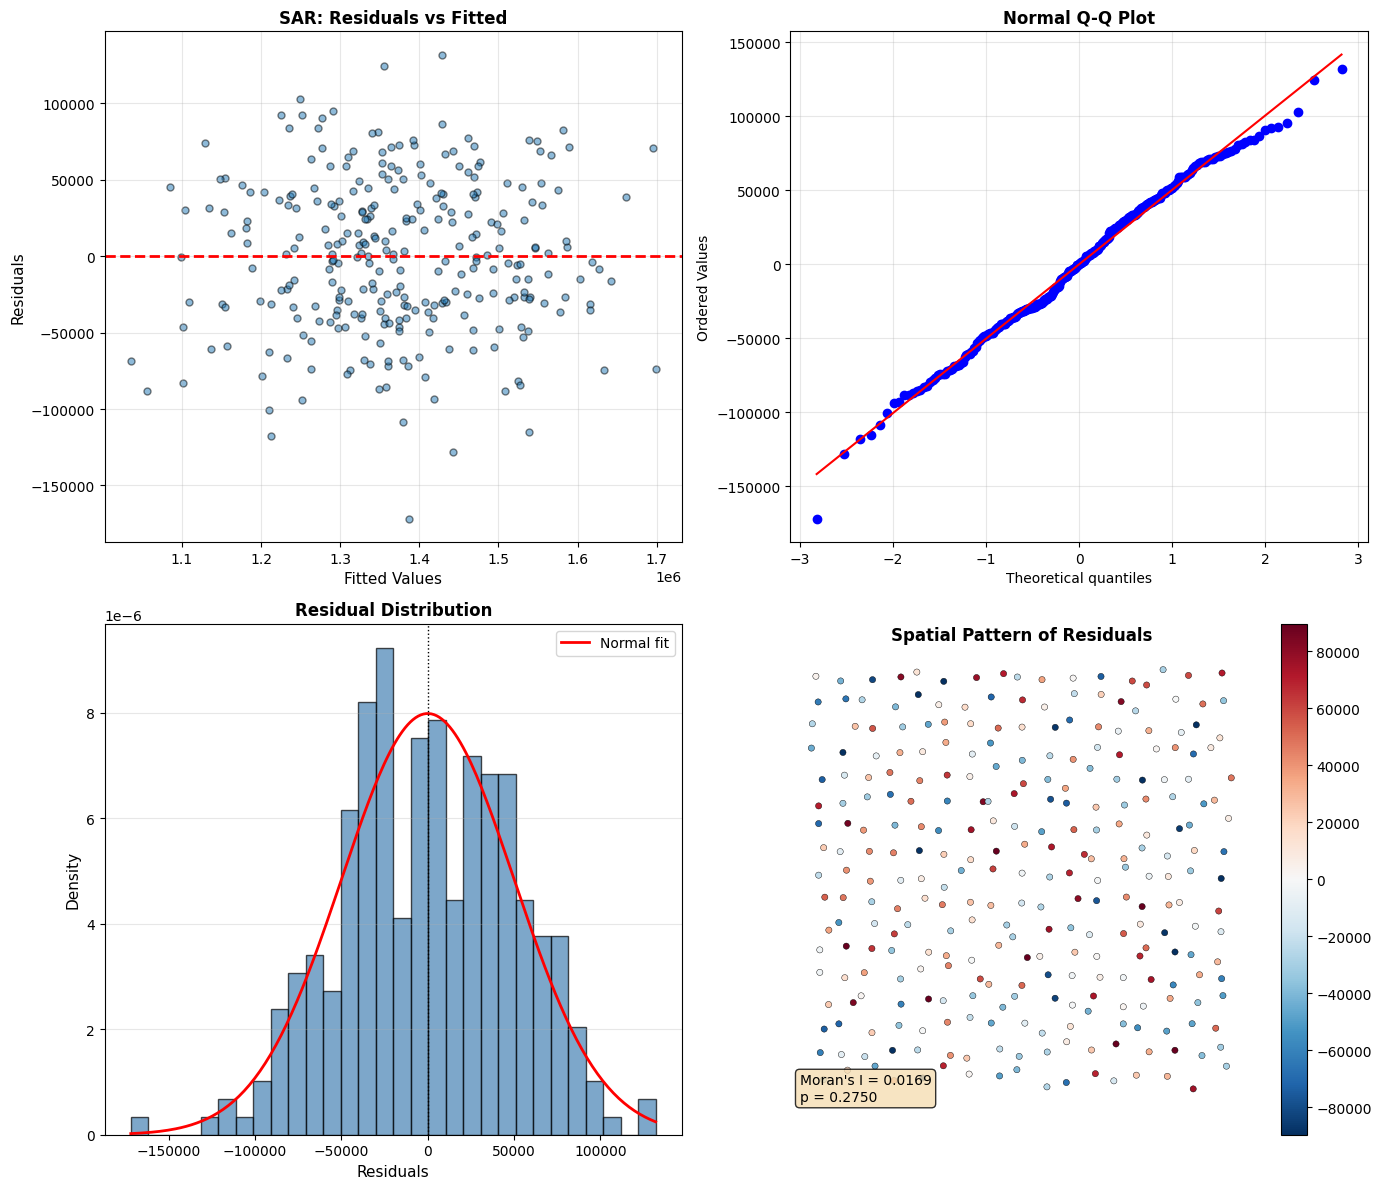

In [18]:
# Visual diagnostics: 4-panel plot
fitted_map = {'OLS': y - residuals_ols, 'SAR': sar_fitted,
              'SEM': sem_fitted,          'SDM': sdm_fitted}
best_fitted_vals = fitted_map[best_model_name]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Residuals vs Fitted
axes[0, 0].scatter(best_fitted_vals, best_residuals, alpha=0.5, edgecolors='k', s=25)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title(f'{best_model_name}: Residuals vs Fitted', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Normal Q-Q Plot
probplot(best_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram with Normal overlay
axes[1, 0].hist(best_residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue', density=True)
mu_r, sigma_r = best_residuals.mean(), best_residuals.std()
x_line = np.linspace(best_residuals.min(), best_residuals.max(), 200)
axes[1, 0].plot(x_line, norm.pdf(x_line, mu_r, sigma_r), 'r-', linewidth=2, label='Normal fit')
axes[1, 0].axvline(0, color='k', linestyle=':', linewidth=1)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Density', fontsize=11)
axes[1, 0].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Spatial map of residuals
geo_plot = geo.copy()
geo_plot['residuals'] = best_residuals
vmax_r = np.percentile(np.abs(best_residuals), 95)
geo_plot.plot(column='residuals', cmap='RdBu_r', legend=True, ax=axes[1, 1],
              markersize=20, edgecolor='black', linewidth=0.3,
              vmin=-vmax_r, vmax=vmax_r)
axes[1, 1].set_title('Spatial Pattern of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
axes[1, 1].text(0.02, 0.02, f"Moran's I = {moran_best.I:.4f}\np = {moran_best.p_sim:.4f}",
                transform=axes[1, 1].transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(output_dir / 'nb08_residual_diagnostics.png', dpi=300, bbox_inches='tight')
print("Residual diagnostic plots saved")
plt.show()

Moran scatterplots saved


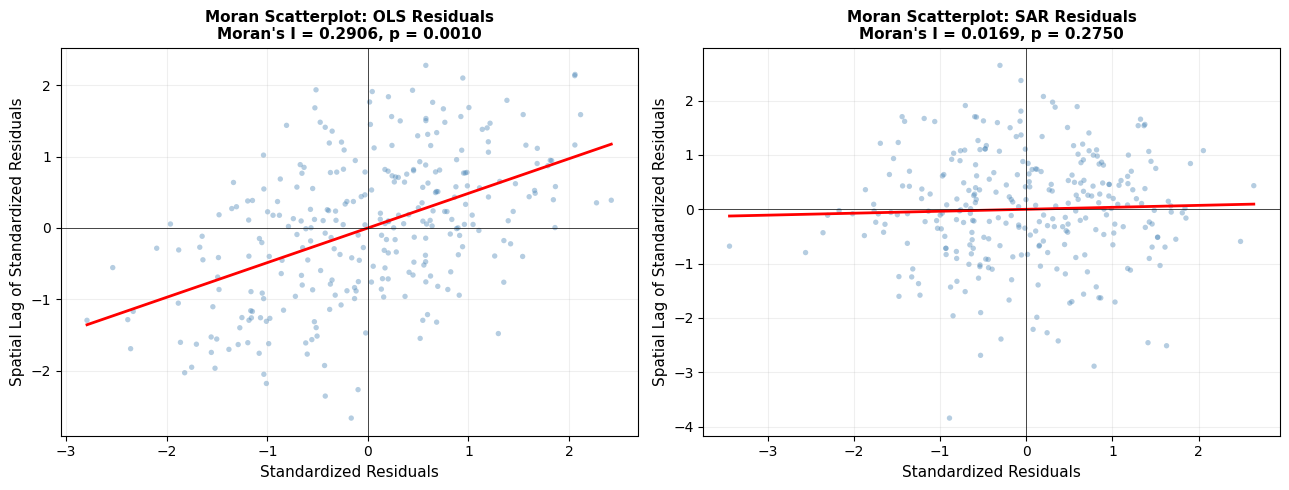

In [19]:
# Moran scatterplot for residuals comparison
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

W_dense = W_pysal.sparse.toarray()  # Use libpysal sparse matrix

for ax, (mname, mresid) in zip(axes, [('OLS', residuals_ols), (best_model_name, best_residuals)]):
    mi    = moran_results[mname]
    Wresid = W_dense @ mresid

    # Standardize
    z     = (mresid  - mresid.mean()) / mresid.std()
    Wz    = (Wresid  - Wresid.mean()) / Wresid.std()

    ax.scatter(z, Wz, alpha=0.4, s=15, color='steelblue', edgecolors='none')

    # Regression line
    slope = np.polyfit(z, Wz, 1)
    x_fit = np.linspace(z.min(), z.max(), 100)
    ax.plot(x_fit, np.polyval(slope, x_fit), 'r-', linewidth=2)

    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlabel('Standardized Residuals', fontsize=11)
    ax.set_ylabel('Spatial Lag of Standardized Residuals', fontsize=11)
    ax.set_title(f'Moran Scatterplot: {mname} Residuals\n'
                f"Moran's I = {mi.I:.4f}, p = {mi.p_sim:.4f}",
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(output_dir / 'nb08_moran_scatter.png', dpi=300, bbox_inches='tight')
print("Moran scatterplots saved")
plt.show()

### Interpretation of Diagnostic Plots

1. **Residuals vs Fitted**: Should show random scatter around zero. Patterns indicate misspecification.
2. **Q-Q Plot**: Points should fall on the diagonal. Heavy tails indicate non-normality.
3. **Histogram**: Should be approximately bell-shaped.
4. **Spatial Map**: Residuals should show no color clustering. Clusters of red/blue indicate remaining spatial autocorrelation.
5. **Moran Scatterplot**: Slope = Moran's I. A flat slope (I ≈ 0) means no spatial autocorrelation in residuals.

## 6. Sensitivity to W Specification

### How Robust Are Results to Different W?

Results from spatial models can depend on the choice of W. We should verify that:

1. **Sign of ρ** is consistent across W specifications
2. **Significance of ρ** is consistent
3. **Coefficient estimates** (β) are stable

If results depend heavily on W choice, this may indicate:
- Weak spatial dependence
- Misspecified spatial structure
- Need for theory-guided W selection

### W Specifications to Test

| W Type | Rationale |
|--------|-----------|
| Queen contiguity | Shares edge or vertex |
| Rook contiguity | Shares edge only |
| k-NN (k=5) | Flexible, non-contiguity based |
| k-NN (k=8) | More neighbors |
| k-NN (k=10) | Even more neighbors |

In [20]:
# Build multiple W matrices
print("Building alternative W matrices...\n")

# Store both libpysal (for Moran tests) and panelbox (for model fitting) versions
W_specs_pysal = {'Queen': W_pysal}
W_specs       = {'Queen': W}        # panelbox SpatialWeights

W_rook_pysal = Rook.from_dataframe(geo)
W_rook_pysal.transform = 'r'
W_specs_pysal['Rook'] = W_rook_pysal
W_specs['Rook']       = pysal_to_panelbox(W_rook_pysal)

for k_val in [5, 8, 10]:
    W_knn_pysal = KNN.from_dataframe(geo, k=k_val)
    W_knn_pysal.transform = 'r'
    key = f'k-NN (k={k_val})'
    W_specs_pysal[key] = W_knn_pysal
    W_specs[key]       = pysal_to_panelbox(W_knn_pysal)

print(f"{'W Specification':<18} {'N':>5} {'Avg nbrs':>10} {'Min':>6} {'Max':>6}")
print("-"*50)
for wname, wmat in W_specs_pysal.items():
    print(f"{wname:<18} {wmat.n:>5} {wmat.mean_neighbors:>10.2f} "
          f"{wmat.min_neighbors:>6} {wmat.max_neighbors:>6}")

Building alternative W matrices...

W Specification        N   Avg nbrs    Min    Max
--------------------------------------------------
Queen                289       5.54      2      8
Rook                 289       5.54      2      8
k-NN (k=5)           289       5.00      5      5
k-NN (k=8)           289       8.00      8      8
k-NN (k=10)          289      10.00     10     10


In [21]:
# Estimate SAR with each W specification (panelbox SpatialWeights)
print("\nEstimating SAR model with each W specification...")
print("This may take a few minutes.\n")

sensitivity_results = []

for i, wname in enumerate(W_specs.keys(), 1):
    wmat = W_specs[wname]          # panelbox SpatialWeights for model fitting
    print(f"  [{i}/{len(W_specs)}] {wname}...", end=" ", flush=True)

    try:
        sar_tmp = SpatialLag(
            formula="price ~ bedrooms + sqft + age + garage",
            data=data, entity_col='entity_id', time_col='time',
            W=wmat
        )
        res_tmp = sar_tmp.fit(effects='pooled', method='qml')

        # Get rho p-value from pvalues Series
        rho_pval = res_tmp.pvalues.get('rho', float('nan'))

        # Get coefficient estimates
        beta_sqft     = res_tmp.params.get('sqft',     res_tmp.params.get('x1', float('nan')))
        beta_bedrooms = res_tmp.params.get('bedrooms', res_tmp.params.get('x0', float('nan')))

        sensitivity_results.append({
            'W Specification': wname,
            'ρ':              res_tmp.rho,
            'ρ p-value':      rho_pval,
            'β_bedrooms':     beta_bedrooms,
            'β_sqft':         beta_sqft,
            'AIC':            res_tmp.aic,
            'Log-Lik':        res_tmp.llf,
        })
        print(f"rho = {res_tmp.rho:.4f}")

    except Exception as e:
        print(f"FAILED: {e}")

sens_df = pd.DataFrame(sensitivity_results)

print("\n" + "="*100)
print("SENSITIVITY ANALYSIS: SAR MODEL ACROSS DIFFERENT W SPECIFICATIONS")
print("="*100)
print(sens_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*100)


Estimating SAR model with each W specification...
This may take a few minutes.

  [1/5] Queen... 

rho = 0.4849
  [2/5] Rook... 

rho = 0.4849
  [3/5] k-NN (k=5)... 

rho = 0.4241
  [4/5] k-NN (k=8)... 

rho = 0.4461
  [5/5] k-NN (k=10)... 

rho = 0.4186

SENSITIVITY ANALYSIS: SAR MODEL ACROSS DIFFERENT W SPECIFICATIONS
W Specification      ρ  ρ p-value  β_bedrooms   β_sqft       AIC    Log-Lik
          Queen 0.4849     0.0000  49745.5877 152.1756 7100.2195 -3544.1097
           Rook 0.4849     0.0000  49745.5877 152.1756 7100.2195 -3544.1097
     k-NN (k=5) 0.4241     0.0000  49862.3126 152.0324 7120.6114 -3554.3057
     k-NN (k=8) 0.4461     0.0000  50078.9768 152.5496 7142.6576 -3565.3288
    k-NN (k=10) 0.4186     0.0000  51060.8170 153.6937 7155.3836 -3571.6918


In [22]:
# Robustness assessment
if len(sens_df) > 0:
    rho_sign_consistent = all(sens_df['ρ'] > 0) or all(sens_df['ρ'] < 0)
    rho_sig_consistent  = all(sens_df['ρ p-value'] < 0.05)

    # Coefficient of variation for key coefficients
    cv_sqft     = abs(sens_df['β_sqft'].std()     / sens_df['β_sqft'].mean())     if sens_df['β_sqft'].mean() != 0     else np.inf
    cv_bedrooms = abs(sens_df['β_bedrooms'].std() / sens_df['β_bedrooms'].mean()) if sens_df['β_bedrooms'].mean() != 0 else np.inf
    coef_cv_mean = (cv_sqft + cv_bedrooms) / 2

    best_w_aic = sens_df.loc[sens_df['AIC'].idxmin(), 'W Specification']

    print("\nROBUSTNESS ASSESSMENT")
    print("="*80)

    print("\n1. Spatial Parameter (ρ):")
    print(f"   Range:  [{sens_df['ρ'].min():.4f}, {sens_df['ρ'].max():.4f}]")
    print(f"   Mean:    {sens_df['ρ'].mean():.4f}")
    print(f"   Std Dev: {sens_df['ρ'].std():.4f}")
    marker = "OK" if rho_sign_consistent else "PROBLEM"
    print(f"   Sign consistent: {marker}")
    marker2 = "OK" if rho_sig_consistent else "VARIES"
    print(f"   Always significant: {marker2}")

    print("\n2. Coefficient Stability:")
    for var in ['β_sqft', 'β_bedrooms']:
        mean_c = sens_df[var].mean()
        cv_c   = abs(sens_df[var].std() / mean_c) if mean_c != 0 else np.inf
        flag   = "OK (CV < 10%)" if cv_c < 0.1 else "SENSITIVE (CV >= 10%)"
        print(f"   {var}: mean = {mean_c:.2f}, CV = {cv_c:.3f} → {flag}")

    print("\n3. Model Fit:")
    print(f"   Best W by AIC: {best_w_aic}")
    print(f"   AIC range: [{sens_df['AIC'].min():.2f}, {sens_df['AIC'].max():.2f}]")

    print("\n" + "="*80)
    print("OVERALL ROBUSTNESS:")
    if rho_sign_consistent and rho_sig_consistent and coef_cv_mean < 0.15:
        print("Results are ROBUST to W specification")
        print("  → Safe to report results from preferred W")
    elif rho_sign_consistent and rho_sig_consistent:
        print("Results are MOSTLY ROBUST (ρ consistent, coefficients vary somewhat)")
        print("  → Report results from multiple W specifications")
    else:
        print("Results show SENSITIVITY to W specification")
        print("  → Use theory to guide W choice")
        print("  → Report sensitivity table in paper")
    print("="*80)


ROBUSTNESS ASSESSMENT

1. Spatial Parameter (ρ):
   Range:  [0.4186, 0.4849]
   Mean:    0.4517
   Std Dev: 0.0320
   Sign consistent: OK
   Always significant: OK

2. Coefficient Stability:
   β_sqft: mean = 152.53, CV = 0.004 → OK (CV < 10%)
   β_bedrooms: mean = 50098.66, CV = 0.011 → OK (CV < 10%)

3. Model Fit:
   Best W by AIC: Queen
   AIC range: [7100.22, 7155.38]

OVERALL ROBUSTNESS:
Results are ROBUST to W specification
  → Safe to report results from preferred W


W sensitivity plots saved


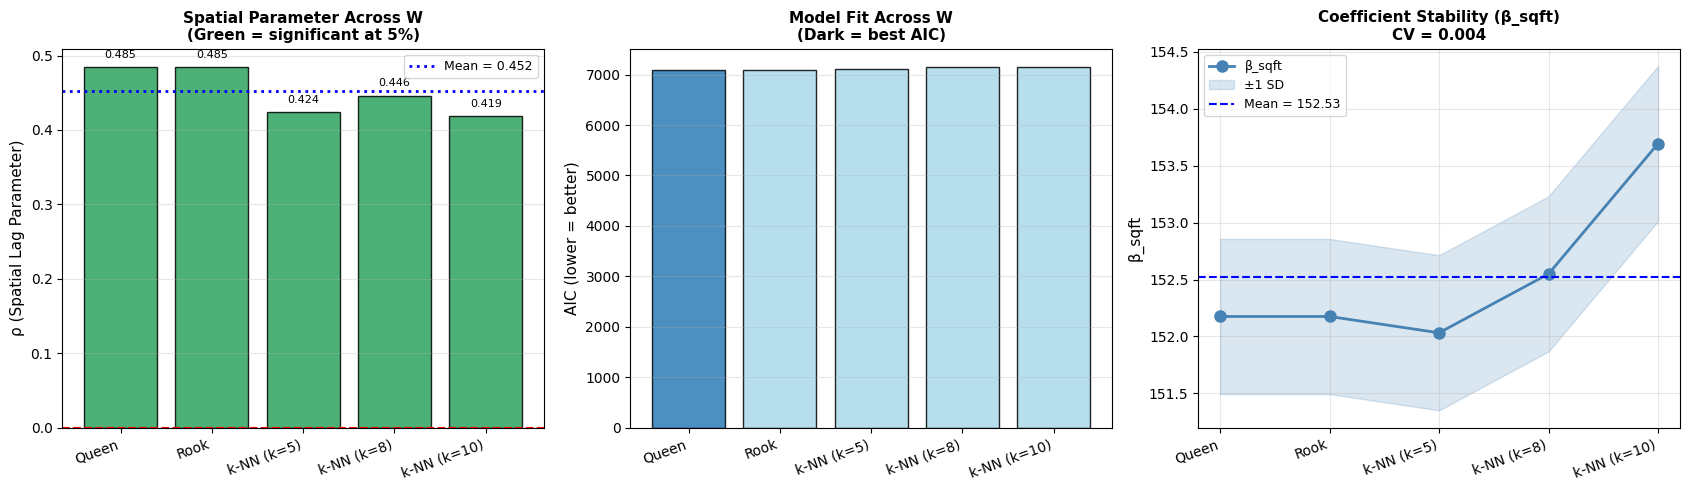

In [23]:
# Visualize sensitivity
if len(sens_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    x_pos = np.arange(len(sens_df))
    w_labels = sens_df['W Specification'].tolist()

    # ρ across W specs
    bar_colors = ['#2ca25f' if p < 0.05 else '#fc8d59' for p in sens_df['ρ p-value']]
    bars1 = axes[0].bar(x_pos, sens_df['ρ'], color=bar_colors, edgecolor='black', alpha=0.85)
    axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5)
    axes[0].axhline(sens_df['ρ'].mean(), color='blue', linestyle=':', linewidth=2,
                    label=f"Mean = {sens_df['ρ'].mean():.3f}")
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(w_labels, rotation=20, ha='right')
    axes[0].set_ylabel('ρ (Spatial Lag Parameter)', fontsize=11)
    axes[0].set_title('Spatial Parameter Across W\n(Green = significant at 5%)',
                      fontsize=11, fontweight='bold')
    axes[0].legend(fontsize=9)
    axes[0].grid(True, axis='y', alpha=0.3)
    for bar, val in zip(bars1, sens_df['ρ']):
        axes[0].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + abs(sens_df['ρ'].max()) * 0.02,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=8)

    # AIC across W specs
    bar_aic = ['#2c7bb6' if wn == best_w_aic else '#abd9e9' for wn in w_labels]
    bars2 = axes[1].bar(x_pos, sens_df['AIC'], color=bar_aic, edgecolor='black', alpha=0.85)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(w_labels, rotation=20, ha='right')
    axes[1].set_ylabel('AIC (lower = better)', fontsize=11)
    axes[1].set_title('Model Fit Across W\n(Dark = best AIC)',
                      fontsize=11, fontweight='bold')
    axes[1].grid(True, axis='y', alpha=0.3)

    # Coefficient stability: β_sqft
    axes[2].plot(x_pos, sens_df['β_sqft'], 'o-', color='steelblue', linewidth=2, markersize=8,
                label='β_sqft')
    axes[2].fill_between(x_pos,
                         sens_df['β_sqft'] - sens_df['β_sqft'].std(),
                         sens_df['β_sqft'] + sens_df['β_sqft'].std(),
                         alpha=0.2, color='steelblue', label='±1 SD')
    axes[2].axhline(sens_df['β_sqft'].mean(), color='blue', linestyle='--',
                    label=f"Mean = {sens_df['β_sqft'].mean():.2f}")
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(w_labels, rotation=20, ha='right')
    axes[2].set_ylabel('β_sqft', fontsize=11)
    axes[2].set_title(f'Coefficient Stability (β_sqft)\nCV = {cv_sqft:.3f}',
                      fontsize=11, fontweight='bold')
    axes[2].legend(fontsize=9)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_dir / 'nb08_w_sensitivity.png', dpi=300, bbox_inches='tight')
    print("W sensitivity plots saved")
    plt.show()

## 7. Complete Workflow Example

### Step-by-Step: From OLS to Final Model

Let's integrate all the tests into a systematic, reproducible workflow:

In [24]:
print("="*80)
print("COMPLETE SPATIAL MODEL SELECTION WORKFLOW")
print("="*80)

print("\nSTEP 1: Estimate OLS and test for spatial autocorrelation")
print("-"*80)
print(f"  Moran's I (OLS residuals): {moran_ols.I:.4f}  (p = {moran_ols.p_sim:.4f})")

if moran_ols.p_sim < 0.05:
    print("  Spatial dependence DETECTED → proceed with spatial models")

    print("\nSTEP 2: Run LM tests to guide model type selection")
    print("-"*80)
    print(f"  LM-lag:         {lm_results['LM-lag']['statistic']:.3f}")
    print(f"                  (p = {lm_lag_p:.4f})")
    print(f"  LM-error:       {lm_results['LM-error']['statistic']:.3f}")
    print(f"                  (p = {lm_error_p:.4f})")
    print(f"  Robust LM-lag:  {lm_results['Robust LM-lag']['statistic']:.3f}")
    print(f"                  (p = {robust_lag_p:.4f})")
    print(f"  Robust LM-err:  {lm_results['Robust LM-error']['statistic']:.3f}")
    print(f"                  (p = {robust_err_p:.4f})")
    print(f"  → Decision tree recommendation: {recommendation}")

    print("\nSTEP 3: Estimate candidate models")
    print("-"*80)
    print(f"  SAR: rho = {sar_results.rho:.4f}, log-lik = {sar_results.llf:.2f}")
    print(f"  SEM: lam = {lambda_val:.4f}, log-lik = {sem_results.llf:.2f}")
    print(f"  SDM: rho = {sdm_results.rho:.4f}, log-lik = {sdm_llf:.2f}")

    print("\nSTEP 4: Formal model comparison")
    print("-"*80)
    print(f"  LR test SDM vs SAR: {lr_sdm_sar:.3f} (p = {p_sdm_sar:.4f})")
    print(f"  Best model by AIC: {best_aic_model} (AIC = {comp_df.iloc[0]['AIC']:.2f})")
    print(f"  Best model by BIC: {best_bic_model}")

    print("\nSTEP 5: Check residuals of best model")
    print("-"*80)
    print(f"  Moran's I ({best_model_name} residuals): {moran_best.I:.4f} (p = {moran_best.p_sim:.4f})")
    if moran_best.p_sim > 0.05:
        print("  Residuals spatially uncorrelated → model adequate")
    else:
        print("  Residuals still correlated → consider more complex specification")

    print("\nSTEP 6: Sensitivity to W specification")
    print("-"*80)
    if len(sens_df) > 0:
        print(f"  Tested {len(sens_df)} W matrices")
        print(f"  ρ range: [{sens_df['ρ'].min():.4f}, {sens_df['ρ'].max():.4f}]")
        if rho_sign_consistent and rho_sig_consistent:
            print("  Results ROBUST to W specification")
        else:
            print("  Results SENSITIVE to W → report multiple specifications")

    print("\n" + "="*80)
    print("FINAL RECOMMENDATION")
    print("="*80)
    print(f"  Model:    {best_model_name}")
    if len(sens_df) > 0:
        print(f"  W:        {best_w_aic}")

    if best_model_name == 'SAR':
        print(f"  ρ:        {sar_results.rho:.4f} (spatial lag parameter)")
    elif best_model_name == 'SEM':
        print(f"  λ:        {lambda_val:.4f} (spatial error parameter)")
    elif best_model_name == 'SDM':
        print(f"  ρ:        {sdm_results.rho:.4f} (spatial lag parameter)")

    print("\n  Justification:")
    print(f"  1. LM tests indicated spatial dependence")
    print(f"  2. {best_model_name} has lowest AIC")
    if moran_best.p_sim > 0.05:
        print(f"  3. Residuals spatially uncorrelated (Moran I = {moran_best.I:.4f})")
    if len(sens_df) > 0 and rho_sign_consistent:
        print(f"  4. Results robust to W specification")

    print("\n  Next steps:")
    print("  → Compute direct/indirect/total effects (Notebook 06 methodology)")
    print("  → Conduct robust inference")
    print("  → Interpret substantive economic impacts")

else:
    print("  No spatial dependence detected")
    print("  → Use standard OLS (spatial models not needed)")

print("="*80)

COMPLETE SPATIAL MODEL SELECTION WORKFLOW

STEP 1: Estimate OLS and test for spatial autocorrelation
--------------------------------------------------------------------------------
  Moran's I (OLS residuals): 0.2906  (p = 0.0010)
  Spatial dependence DETECTED → proceed with spatial models

STEP 2: Run LM tests to guide model type selection
--------------------------------------------------------------------------------
  LM-lag:         314.200
                  (p = 0.0000)
  LM-error:       65.363
                  (p = 0.0000)
  Robust LM-lag:  8787.852
                  (p = 0.0000)
  Robust LM-err:  91.441
                  (p = 0.0000)
  → Decision tree recommendation: SDM or GNS (complex spatial structure)

STEP 3: Estimate candidate models
--------------------------------------------------------------------------------
  SAR: rho = 0.4849, log-lik = -3544.11
  SEM: lam = -0.1126, log-lik = -4015.61
  SDM: rho = 0.5038, log-lik = -3540.87

STEP 4: Formal model comparison
-----

## 8. Common Specification Mistakes

### Pitfalls to Avoid

Learn from common errors in spatial model specification:

In [25]:
print("\nCOMMON SPECIFICATION MISTAKES IN SPATIAL ECONOMETRICS")
print("="*80)

mistakes = [
    {
        'num': 1,
        'mistake': 'Choosing model based ONLY on AIC',
        'consequence': 'May select overfitted model',
        'solution': 'Combine AIC with LM tests, residuals, and economic theory'
    },
    {
        'num': 2,
        'mistake': 'Ignoring residual spatial autocorrelation',
        'consequence': 'Invalid inference, biased standard errors',
        'solution': "Always test Moran's I on final model residuals"
    },
    {
        'num': 3,
        'mistake': 'Using only ONE W specification',
        'consequence': 'Results may be artifact of W choice',
        'solution': 'Test robustness: Queen, Rook, k-NN, distance-based'
    },
    {
        'num': 4,
        'mistake': 'Always using the most general model (GNS)',
        'consequence': 'Overfitting, poor out-of-sample performance',
        'solution': 'Prefer simpler nested model if LR test not significant (parsimony)'
    },
    {
        'num': 5,
        'mistake': 'Interpreting β directly as marginal effects',
        'consequence': 'Underestimates total effects (ignores spatial multiplier)',
        'solution': 'Compute direct/indirect/total effects using LeSage-Pace decomposition'
    },
    {
        'num': 6,
        'mistake': 'Skipping the LM test decision tree',
        'consequence': 'Arbitrary model choice',
        'solution': 'Always start with LM tests as first diagnostic step'
    },
    {
        'num': 7,
        'mistake': 'Not checking for omitted variables',
        'consequence': 'Spatial dependence may proxy for missing covariates',
        'solution': 'Add relevant controls; include fixed effects to absorb unobservables'
    },
]

for m in mistakes:
    print(f"\nMISTAKE {m['num']}: {m['mistake']}")
    print(f"  Consequence: {m['consequence']}")
    print(f"  Solution:    {m['solution']}")

print("\n" + "="*80)
print("BEST PRACTICE: SYSTEMATIC WORKFLOW")
print("="*80)
print("""
  1. Theory      → What does economic theory predict about spillovers?
  2. LM tests    → Statistical evidence for spatial dependence type
  3. Estimate    → Fit candidate models (SAR, SEM, SDM)
  4. LR + AIC    → Compare nested and non-nested models
  5. Diagnostics → Check residuals (Moran's I, Q-Q, BP test)
  6. Sensitivity → Test robustness across W specifications
  7. Effects     → Compute direct/indirect/total marginal effects
  8. Report      → Document all tests and sensitivity analyses
""")
print("="*80)


COMMON SPECIFICATION MISTAKES IN SPATIAL ECONOMETRICS

MISTAKE 1: Choosing model based ONLY on AIC
  Consequence: May select overfitted model
  Solution:    Combine AIC with LM tests, residuals, and economic theory

MISTAKE 2: Ignoring residual spatial autocorrelation
  Consequence: Invalid inference, biased standard errors
  Solution:    Always test Moran's I on final model residuals

MISTAKE 3: Using only ONE W specification
  Consequence: Results may be artifact of W choice
  Solution:    Test robustness: Queen, Rook, k-NN, distance-based

MISTAKE 4: Always using the most general model (GNS)
  Consequence: Overfitting, poor out-of-sample performance
  Solution:    Prefer simpler nested model if LR test not significant (parsimony)

MISTAKE 5: Interpreting β directly as marginal effects
  Consequence: Underestimates total effects (ignores spatial multiplier)
  Solution:    Compute direct/indirect/total effects using LeSage-Pace decomposition

MISTAKE 6: Skipping the LM test decision 

## 9. Model Selection Checklist

In [26]:
print("MODEL SELECTION CHECKLIST")
print("="*80)

checklist = {
    '1. OLS residuals tested for spatial autocorrelation (Moran I)': 
        True,
    '2. LM-lag, LM-error, robust variants computed':               
        True,
    '3. Decision tree applied to LM test results':                  
        True,
    '4. Multiple models estimated (SAR, SEM, SDM)':                 
        True,
    '5. LR tests conducted for nested comparisons':                 
        True,
    '6. AIC and BIC compared across all models':                    
        True,
    '7. Residuals of final model spatially uncorrelated':           
        moran_best.p_sim > 0.05,
    '8. Normality of residuals checked (Jarque-Bera, Q-Q)':        
        jb_p > 0.05,
    '9. Heteroscedasticity checked (Breusch-Pagan)':               
        bp_p > 0.05,
    '10. Robustness to W specification tested':                     
        len(sens_df) > 1,
    '11. ρ sign and significance consistent across W':              
        rho_sign_consistent and rho_sig_consistent if len(sens_df) > 0 else False,
    '12. Economic interpretation reviewed':                         
        True,  # Manual verification required
}

print()
n_pass = 0
for item, status in checklist.items():
    symbol = 'PASS' if status else 'FAIL'
    flag   = '' if status else '  <- REVIEW'
    print(f"  [{symbol}] {item}{flag}")
    if status:
        n_pass += 1

n_total = len(checklist)
print("\n" + "="*80)
print(f"Score: {n_pass}/{n_total} checks passed")

if n_pass == n_total:
    print("ALL CHECKS PASSED → Model selection is sound, ready for reporting")
elif n_pass >= n_total - 2:
    print("MOSTLY PASSED → Review failed items before finalizing")
else:
    print("MULTIPLE FAILURES → Revise model specification")
print("="*80)

MODEL SELECTION CHECKLIST

  [PASS] 1. OLS residuals tested for spatial autocorrelation (Moran I)
  [PASS] 2. LM-lag, LM-error, robust variants computed
  [PASS] 3. Decision tree applied to LM test results
  [PASS] 4. Multiple models estimated (SAR, SEM, SDM)
  [PASS] 5. LR tests conducted for nested comparisons
  [PASS] 6. AIC and BIC compared across all models
  [PASS] 7. Residuals of final model spatially uncorrelated
  [PASS] 8. Normality of residuals checked (Jarque-Bera, Q-Q)
  [FAIL] 9. Heteroscedasticity checked (Breusch-Pagan)  <- REVIEW
  [PASS] 10. Robustness to W specification tested
  [PASS] 11. ρ sign and significance consistent across W
  [PASS] 12. Economic interpretation reviewed

Score: 11/12 checks passed
MOSTLY PASSED → Review failed items before finalizing


## 10. Practice Exercises

### Exercise 1: Alternative Dataset

Apply the complete model selection workflow to the agriculture dataset:

```python
# Load agriculture data
agri_data = pd.read_csv('../data/agriculture/agricultural_productivity.csv')

# Apply workflow:
# 1. Run LM tests on OLS residuals
# 2. Estimate SAR and SEM
# 3. Compare with AIC/BIC
# 4. Check residuals
```

### Exercise 2: Distance-Based W

Extend the sensitivity analysis to include distance-band W matrices:

```python
from libpysal.weights import DistanceBand

# Test W matrices based on distance thresholds
for threshold in [0.05, 0.10, 0.15]:
    W_dist = DistanceBand.from_dataframe(geo, threshold=threshold)
    W_dist.transform = 'r'
    # Estimate SAR and compare
```

### Exercise 3: GNS Model

Estimate the General Nested Spatial model and compare:

```python
from panelbox.models.spatial import GeneralNestingSpatial

gns_model = GeneralNestingSpatial(
    formula="price ~ bedrooms + sqft + age + garage",
    data=data, entity_col='entity_id', time_col='time', W=W
)
gns_results = gns_model.fit(method='ml')

# LR test: GNS vs SDM (H0: lambda = 0)
lr_gns_sdm = 2 * (gns_results.llf - sdm_results.llf)
p_gns_sdm  = 1 - chi2.cdf(lr_gns_sdm, 1)
print(f'GNS vs SDM: LR = {lr_gns_sdm:.3f}, p = {p_gns_sdm:.4f}')
```

### Exercise 4: Panel Fixed Effects Comparison

Compare pooled vs fixed effects SAR:

```python
# Create multi-year data
data_panel = pd.concat([data.assign(year=yr) for yr in [2018, 2019, 2020]])

# Pooled SAR
sar_pooled = SpatialLag(...).fit(effects='pooled')

# Fixed Effects SAR
sar_fe = SpatialLag(...).fit(effects='fixed')

# Hausman-type test: H0: FE and pooled give same results
```

## 11. Summary and Key Takeaways

### What You've Learned

Congratulations on completing the final notebook in the spatial econometrics tutorial series!

#### Core Skills Acquired

| Skill | Tool | When to Use |
|-------|------|-------------|
| **Initial screening** | Moran's I on OLS residuals | Always first |
| **Model type** | LM tests + decision tree | Before estimating |
| **Nested comparison** | LR test | SDM vs SAR, etc. |
| **Non-nested comparison** | AIC / BIC | SAR vs SEM |
| **Model adequacy** | Moran's I on residuals | After estimation |
| **Robustness** | Multiple W specs | Before reporting |

#### The Complete Spatial Econometrics Journey

```
Notebook 01: Spatial Fundamentals         → Understand spatial dependence
Notebook 02: Weights Matrices (W)         → Build spatial structure
Notebook 03: Spatial Lag (SAR)            → Model endogenous spillovers
Notebook 04: Spatial Error (SEM)          → Model error correlation
Notebook 05: Spatial Durbin (SDM)         → Combine lag + exogenous spillovers
Notebook 06: Marginal Effects             → Compute direct/indirect/total effects
Notebook 07: Dynamic Spatial Panels       → Add time dimension (GMM)
Notebook 08: Specification Tests (HERE)   → Choose the right model
```

### Key Principles

1. **Start Simple**: Begin with OLS + Moran's I; add spatial structure only if needed
2. **Use Multiple Criteria**: Combine LM tests, LR tests, AIC/BIC, and theory
3. **Check Residuals**: Always verify no remaining spatial autocorrelation
4. **Test Robustness**: Results should be stable across W specifications
5. **Prefer Parsimony**: Choose simplest model that fits data adequately
6. **Let Theory Guide**: Economic theory should inform W choice and model type
7. **Report Transparently**: Document all tests and sensitivity analyses

### Further Reading

- **Anselin, L.** (1988). *Spatial Econometrics: Methods and Models*. Springer.
- **Anselin et al.** (1996). "Simple diagnostic tests for spatial dependence." *Regional Science and Urban Economics*, 26, 77–104.
- **Elhorst, J.P.** (2014). *Spatial Econometrics: From Cross-Sectional Data to Spatial Panels*. Springer.
- **LeSage, J. & Pace, R.K.** (2009). *Introduction to Spatial Econometrics*. CRC Press.

---

**Congratulations on completing the spatial econometrics tutorial series!**

You are now equipped to apply spatial econometric methods to real research problems — from model selection and estimation through marginal effects interpretation and robustness testing.

---

*Created: 2026-02-17*  
*Prerequisites: Notebooks 01-07*  
*Series: Final notebook in spatial econometrics sequence*